# Read Data Sample

In [1]:
import pandas as pd
import numpy as np
pd.set_option("display.max_rows",35)
%matplotlib inline

In [2]:
class dataset:
    kdd_train_2labels = pd.read_pickle("dataset/kdd_train_2labels.pkl")
    kdd_test_2labels = pd.read_pickle("dataset/kdd_test_2labels.pkl")
    
    kdd_train_5labels = pd.read_pickle("dataset/kdd_train_5labels.pkl")
    kdd_test_5labels = pd.read_pickle("dataset/kdd_test_5labels.pkl")
    

In [3]:
dataset.kdd_train_2labels.shape

(125973, 124)

In [4]:
dataset.kdd_test_2labels.shape

(22544, 124)

In [5]:
from sklearn import model_selection as ms
from sklearn import preprocessing as pp

class preprocess:
    
    output_columns_2labels = ['is_Attack','is_Normal']
    
    x_input = dataset.kdd_train_2labels.drop(output_columns_2labels, axis = 1)
    y_output = dataset.kdd_train_2labels.loc[:,output_columns_2labels]

    x_test_input = dataset.kdd_test_2labels.drop(output_columns_2labels, axis = 1)
    y_test = dataset.kdd_test_2labels.loc[:,output_columns_2labels]

    ss = pp.StandardScaler()

    x_train = ss.fit_transform(x_input)
    x_test = ss.transform(x_test_input)

    y_train = y_output.values


In [6]:
import tensorflow as tf


In [7]:
class network(object):
    
    input_dim = 122
    classes = 2
    hidden_encoder_dim = 80
    hidden_layers = 1
    latent_dim = 10

    hidden_decoder_dim = 80
    lam = 0.01
    
    def __init__(self, classes, hidden_layers, num_of_features):
        self.classes = classes
        self.hidden_layers = hidden_layers
        self.latent_dim = num_of_features
            
    def build_layers(self):
        tf.reset_default_graph()
        #learning_rate = tf.Variable(initial_value=0.001)

        input_dim = self.input_dim
        classes = self.classes
        hidden_encoder_dim = self.hidden_encoder_dim
        hidden_layers = self.hidden_layers
        latent_dim = self.latent_dim
        hidden_decoder_dim = self.hidden_decoder_dim
        lam = self.lam
        
        with tf.variable_scope("Input"):
            self.x = tf.placeholder("float", shape=[None, input_dim])
            self.y_ = tf.placeholder("float", shape=[None, classes])
            self.keep_prob = tf.placeholder("float")
        
        with tf.variable_scope("Layer_Encoder"):

            hidden_encoder = tf.layers.dense(self.x, hidden_encoder_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
            for h in range(hidden_layers - 1):
                hidden_encoder = tf.layers.dense(hidden_encoder, hidden_encoder_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
            
        with tf.variable_scope("Layer_Mean"):
            mu_encoder = tf.layers.dense(hidden_encoder, latent_dim, activation = None, kernel_regularizer=tf.nn.l2_loss)

        with tf.variable_scope("Layer_Variance"):
            logvar_encoder = tf.layers.dense(hidden_encoder, latent_dim, activation = None, kernel_regularizer=tf.nn.l2_loss)

        with tf.variable_scope("Sampling_Distribution"):
            # Sample epsilon
            epsilon = tf.random_normal(tf.shape(logvar_encoder), mean=0.0, stddev=0.05, name='epsilon')

            # Sample latent variable
            std_encoder = tf.exp(0.5 * logvar_encoder)
            z = mu_encoder + tf.multiply(std_encoder, epsilon)
            
            tf.summary.histogram("Sample_Distribution", z)

        with tf.variable_scope("Layer_Decoder"):
            hidden_decoder = tf.layers.dense(z, hidden_decoder_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
            for h in range(hidden_layers - 1):
                hidden_decoder = tf.layers.dense(hidden_decoder, hidden_decoder_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)

        with tf.variable_scope("Layer_Reconstruction"):
            x_hat = tf.layers.dense(hidden_decoder, input_dim, activation = None)
            
        with tf.variable_scope("Layer_Dense_Hidden"):
            hidden_output = tf.layers.dense(z,latent_dim, activation=tf.nn.relu)

        with tf.variable_scope("Layer_Dense_Softmax"):
            y = tf.layers.dense(z, classes, activation=tf.nn.softmax)

        with tf.variable_scope("Loss"):
            BCE = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(logits=x_hat, labels=self.x), reduction_indices=1)
            KLD = -0.5 * tf.reduce_sum(1 + logvar_encoder - tf.pow(mu_encoder, 2) - tf.exp(logvar_encoder), reduction_indices=1)
            softmax_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = self.y_, logits = y))

            loss = tf.reduce_mean(BCE + KLD + softmax_loss)

            self.regularized_loss = tf.abs(loss, name = "Regularized_loss")
            correct_prediction = tf.equal(tf.argmax(self.y_, 1), tf.argmax(y, 1))
            self.tf_accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name = "Accuracy")

        with tf.variable_scope("Optimizer"):
            learning_rate=0.001
            train_op = tf.train.AdamOptimizer(learning_rate)
            self.optimizer = train_op.minimize(self.regularized_loss)  
            
        # add op for merging summary
        self.summary_op = tf.summary.merge_all()
        self.pred = tf.argmax(y, 1)
        self.actual = tf.argmax(self.y_, 1)

        # add Saver ops
        self.saver = tf.train.Saver()
        

In [8]:
import collections

class Train:    
    
    result = collections.namedtuple("result", ["epochs", "hidden_layers", "feature_count",
                                  "Train_Accuracy", "Test_Accuracy"])
    results = []
    best_acc = 0
    
    def train(epochs, net, h,f):
        batch_iterations = 100
    
        with tf.Session() as sess:
            summary_writer_train = tf.summary.FileWriter('./logs/kdd/VAE/training', graph=sess.graph)
            summary_writer_valid = tf.summary.FileWriter('./logs/kdd/VAE/validation')

            sess.run(tf.global_variables_initializer())

            for epoch in range(1, (epochs+1)):
                x_train, x_valid, y_train, y_valid, = ms.train_test_split(preprocess.x_train, 
                                                                          preprocess.y_train, 
                                                                          test_size=0.4)
                batch_indices = np.array_split(np.arange(x_train.shape[0]), 
                                           batch_iterations)
                                                                          
                for i in batch_indices:
                    _, train_loss, summary_str = sess.run([net.optimizer, 
                                                           net.regularized_loss, 
                                                           net.summary_op],
                                                          feed_dict={net.x: x_train[i,:], 
                                                                     net.y_: y_train[i,:], 
                                                                     net.keep_prob:0.8})
                    summary_writer_train.add_summary(summary_str, epoch)


                valid_accuracy, summary_str = sess.run([net.tf_accuracy, net.summary_op], 
                                                      feed_dict={net.x: x_valid, 
                                                                 net.y_: y_valid, 
                                                                 net.keep_prob:1})
                summary_writer_valid.add_summary(summary_str, epoch)

                if epoch % 10 == 0:
                    print("Step {} | Training Loss: {:.6f} | Validation Accuracy: {:.6f}".format(epoch, train_loss, valid_accuracy))

            accuracy, pred_value, actual_value = sess.run([net.tf_accuracy, 
                                                           net.pred, 
                                                           net.actual], 
                                                          feed_dict={net.x: preprocess.x_test, 
                                                                     net.y_: preprocess.y_test, 
                                                                     net.keep_prob:1})


            print("Accuracy on Test data: {}".format(accuracy))
            if accuracy > Train.best_acc:
                Train.best_acc = accuracy
                Train.pred_value = pred_value
                Train.actual_value = actual_value
                Train.best_parameters = "Hidden Layers:{}, Features Count:{}".format(h, f)
                net.saver.save(sess, "dataset/epochs_{}_hidden layers_{}_features count_{}".format(epochs,h,f))
            Train.results.append(Train.result(epochs, h, f,valid_accuracy, accuracy))
            

In [9]:
import itertools
class Hyperparameters:
    features_arr = [2, 4, 8, 16, 32, 64, 128, 256]
    hidden_layers_arr = [2, 4, 6, 10]
    epochs = [1]
    
    for e, h, f in itertools.product(epochs, hidden_layers_arr, features_arr):
        print("Current Layer Attributes - epochs:{} hidden layers:{} features count:{}".format(e,h,f))
        n = network(2,h,f)
        n.build_layers()
        Train.train(e, n, h,f)
        

Current Layer Attributes - epochs:1 hidden layers:2 features count:2
Accuracy on Test data: 0.7159332633018494
Current Layer Attributes - epochs:1 hidden layers:2 features count:4
Accuracy on Test data: 0.4838537871837616
Current Layer Attributes - epochs:1 hidden layers:2 features count:8
Accuracy on Test data: 0.49889105558395386
Current Layer Attributes - epochs:1 hidden layers:2 features count:16
Accuracy on Test data: 0.8440826535224915
Current Layer Attributes - epochs:1 hidden layers:2 features count:32
Accuracy on Test data: 0.7944907546043396
Current Layer Attributes - epochs:1 hidden layers:2 features count:64
Accuracy on Test data: 0.8049591779708862
Current Layer Attributes - epochs:1 hidden layers:2 features count:128
Accuracy on Test data: 0.7340756058692932
Current Layer Attributes - epochs:1 hidden layers:2 features count:256
Accuracy on Test data: 0.8760645985603333
Current Layer Attributes - epochs:1 hidden layers:4 features count:2
Accuracy on Test data: 0.6251774430

In [11]:
df_results = pd.DataFrame(Train.results)

In [12]:
df_results

,epochs,hidden_layers,feature_count,Train_Accuracy,Test_Accuracy
0,1,2,2,0.866700,0.715933
1,1,2,4,0.478567,0.483854
2,1,2,8,0.616749,0.498891
3,1,2,16,0.807958,0.844083
4,1,2,32,0.805934,0.794491
5,1,2,64,0.862631,0.804959
6,1,2,128,0.861996,0.734076
7,1,2,256,0.896329,0.876065
8,1,4,2,0.836297,0.625177
9,1,4,4,0.771463,0.728176


In [13]:
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    np.set_printoptions(precision=4)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j].round(4),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix
[[ 0.8233  0.1767]
 [ 0.0543  0.9457]]


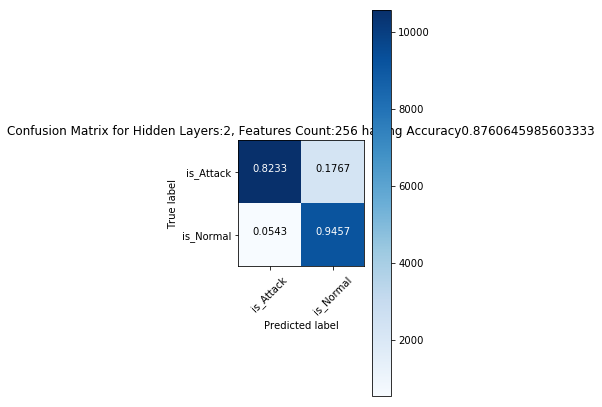

In [15]:
from sklearn.metrics import confusion_matrix
cm_2labels = confusion_matrix(y_pred = Train.pred_value, y_true = Train.actual_value)
plt.figure(figsize=[6,6])
plot_confusion_matrix(cm_2labels, preprocess.output_columns_2labels, normalize = True,
                             title = "Confusion Matrix for {} having Accuracy{}".format(Train.best_parameters, Train.best_acc ))